# Proyecto Final
## Behavioural Cloning

---

### Integrantes del Equipo 23:
* Carlos Pano Hernández - A01066264 [Campus Estado de México]
* Marie Kate Palau - A01705711 [Campus Monterrey]
* Edson Ulises Rodríguez Dávalos - A01796057 [Campus CdMx]
* Yohanna Ceballos Salomón - A01795115 [Campus Monterrey]

---

### Escuela de Ingeniería y Ciencias, Tecnológico de Monterrey
**Navegación autónoma (MR4010 - Gpo 10)**

---

#### Profesor Titular:
Dr. David Antonio Torres

#### Profesor Asistente:
Mtra. María Mylen Treviño Elizondo

---

**Martes 17 de junio del 2025**

# 1. Library Imports and Setup
This section contains all the necessary library imports for data manipulation, image processing, deep learning, and visualization that we'll use throughout this notebook.

Image dimensions: 320x160

Dataset Split:
Set          Samples    Shape          
----------------------------------------
Train        306        (306, 160, 320, 3)
Validation   66         (66, 160, 320, 3)
Test         66         (66, 160, 320, 3)
Epoch 1/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - cosine_similarity: -0.0019 - loss: 0.0094 - val_cosine_similarity: 0.1667 - val_loss: 0.0044
Epoch 2/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 176ms/step - cosine_similarity: 0.2611 - loss: 0.0049 - val_cosine_similarity: 0.1667 - val_loss: 0.0043
Epoch 3/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 181ms/step - cosine_similarity: 0.1950 - loss: 0.0057 - val_cosine_similarity: 0.1667 - val_loss: 0.0044
Epoch 4/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 186ms/step - cosine_similarity: 0.2337 - loss: 0.0064 - val_cosine_similarity: 0.1667 - val_loss: 0.0043
Epoch 5/20
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - cosine_similarity: 0.2445 - loss: 0.0046 - val_cosine_similarity: 0.1667 - val_loss: 0.0043
Epoch 6/20
10/10 ━━

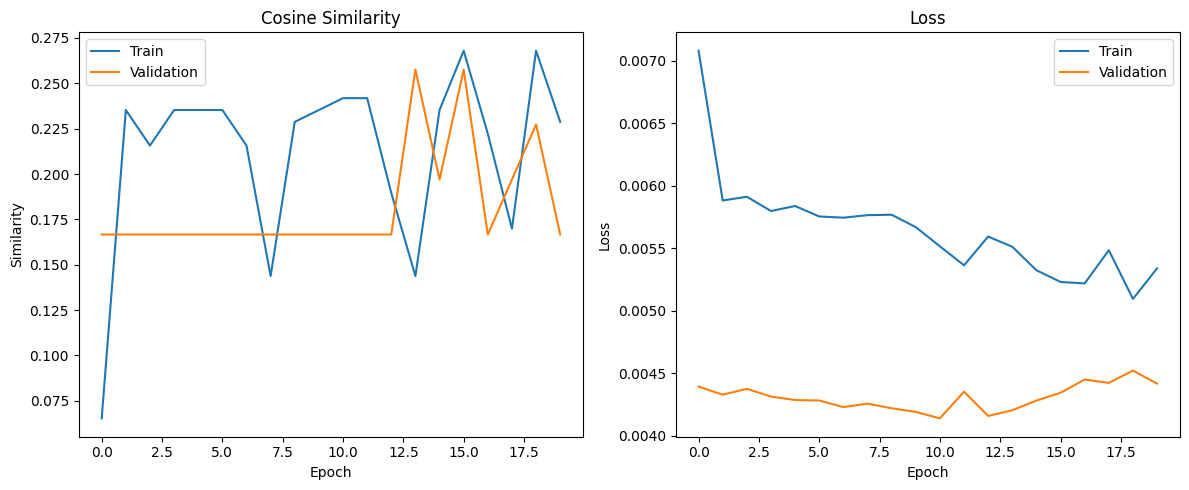

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


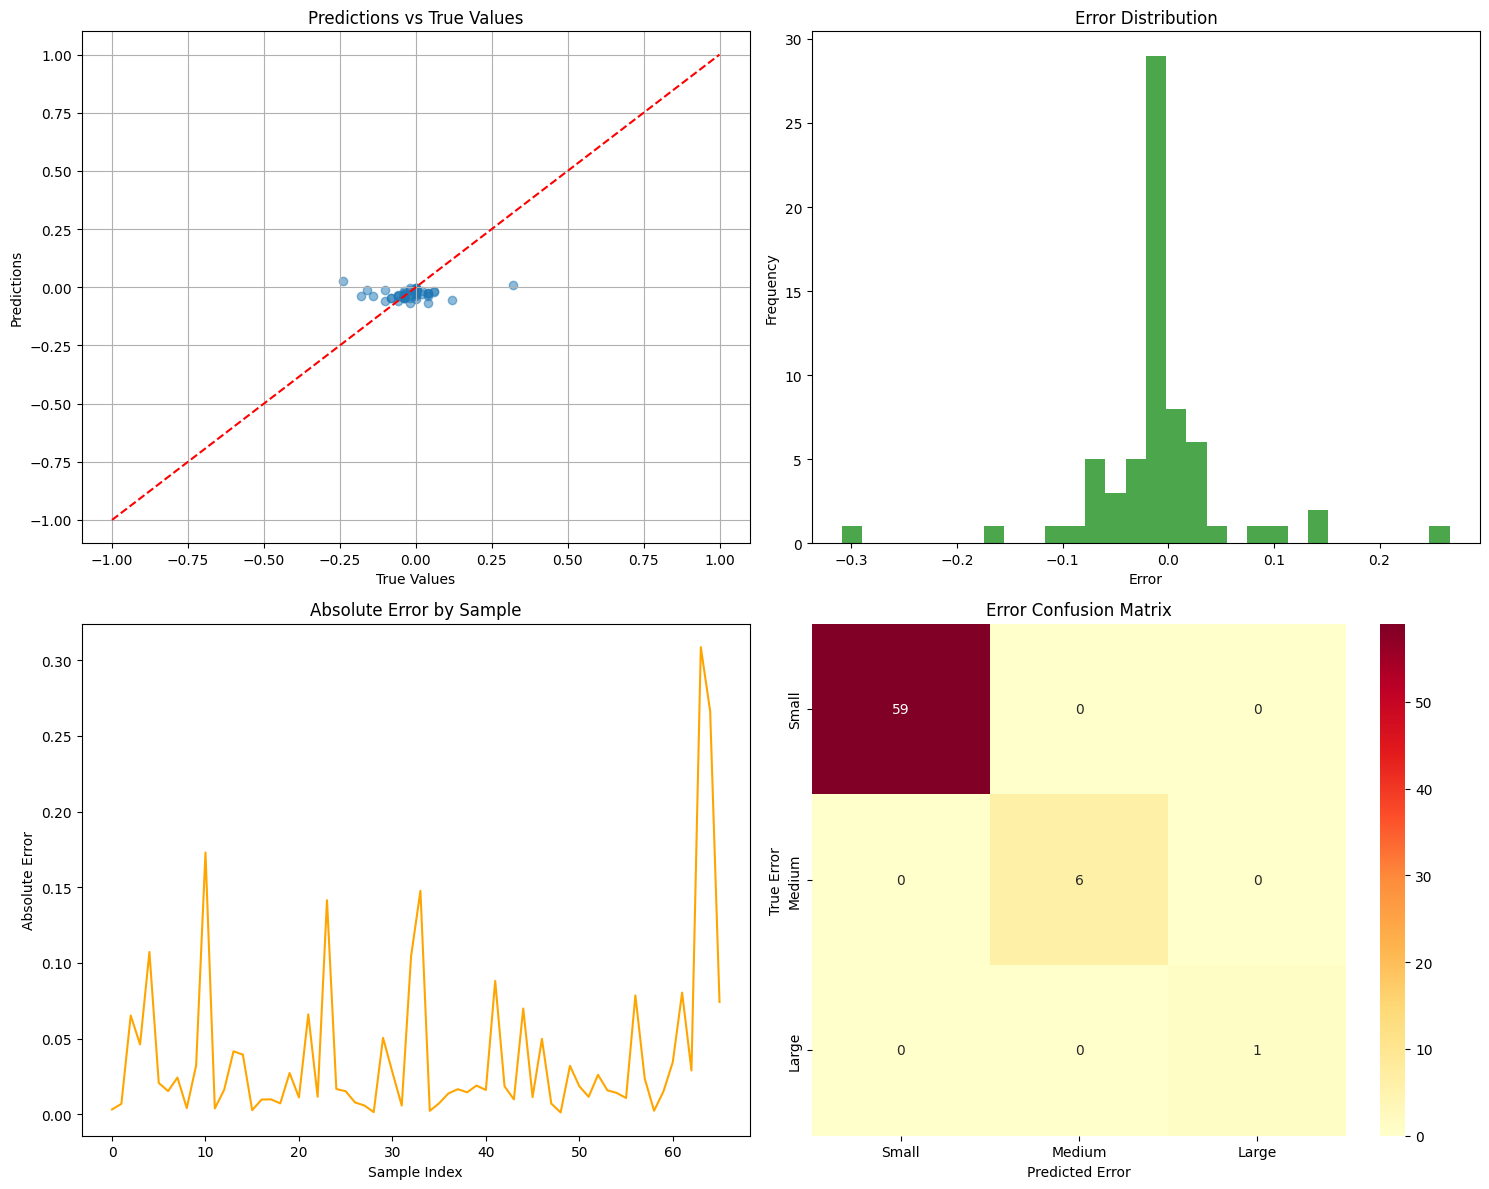


Model saved as 'modelo_conduccion.h5'

Predictions for first 10 images:
Image                          Predicted Angle
---------------------------------------------
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2025-06-17_00-57-22-585243.png -0.01°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2025-06-17_00-58-23-399025.png -0.01°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
2025-06-17_00-57-30-256066.png -0.01°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
2025-06-17_01-00-42-714622.png -0.04°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


2025-06-17_01-00-43-226999.png -0.01°
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
2025-06-17_00-58-49-488981.png -0.03°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


2025-06-17_00-58-48-989465.png -0.03°
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2025-06-17_00-58-52-035129.png -0.03°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
2025-06-17_00-57-56-802677.png -0.01°


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
2025-06-17_00-59-00-205761.png -0.01°


In [37]:
# Import all required libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Lambda, Conv2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import CosineSimilarity

# Constants
IMG_PATH = 'data/imagenes_capturadas'
BATCH_SIZE = 32
EPOCHS = 20
RANDOM_STATE = 42

# Get image dimensions from first image
sample_image = Image.open(os.path.join(IMG_PATH, os.listdir(IMG_PATH)[0]))
IMG_WIDTH, IMG_HEIGHT = sample_image.size
print(f"Image dimensions: {IMG_WIDTH}x{IMG_HEIGHT}")

# Image preprocessing function
def load_and_preprocess_image(file_path):
    """Load, resize, convert to RGB and normalize image"""
    img = Image.open(file_path).convert('RGB').resize((IMG_WIDTH, IMG_HEIGHT))
    return np.array(img) / 255.0

# Load and prepare data
train_df = pd.read_csv('data/registro_conduccion.csv')
X = np.array([load_and_preprocess_image(os.path.join(IMG_PATH, fname)) for fname in train_df['nombre_imagen']])
y = train_df['angulo_direccion'].values

# Split data into train, validation and test sets
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.15, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.1765, random_state=RANDOM_STATE)

# Print dataset sizes
print("\nDataset Split:")
print(f"{'Set':<12} {'Samples':<10} {'Shape':<15}")
print("-" * 40)
print(f"{'Train':<12} {len(X_train):<10} {X_train.shape}")
print(f"{'Validation':<12} {len(X_val):<10} {X_val.shape}")
print(f"{'Test':<12} {len(X_test):<10} {X_test.shape}")

# Data augmentation setup
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1
)
val_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(X_train, y_train, batch_size=BATCH_SIZE)
validation_generator = val_datagen.flow(X_val, y_val, batch_size=BATCH_SIZE)

# Build CNN model (DAVE-2 inspired architecture)
model = Sequential([
    Lambda(lambda x: x * 2. - 1., input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)),
    Conv2D(24, (5, 5), strides=(2, 2), activation='elu'),
    Conv2D(36, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(48, (5, 5), strides=(2, 2), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(1164, activation='relu'),
    Dense(100, activation='relu'),
    Dense(50, activation='relu'),
    Dense(10, activation='relu'),
    Dense(1, activation='tanh')
])

# Compile model
model.compile(
    loss='mse',
    optimizer=Adam(learning_rate=1e-4),
    metrics=[CosineSimilarity()]
)

# Train model
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# Evaluate model
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=1)
print("\nModel Evaluation:")
print(f"{'Metric':<20} {'Value':<10}")
print("-" * 30)
print(f"{'Test Accuracy':<20} {test_acc:.4f}")
print(f"{'Test Loss':<20} {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['cosine_similarity'], label='Train')
plt.plot(history.history['val_cosine_similarity'], label='Validation')
plt.title('Cosine Similarity')
plt.xlabel('Epoch')
plt.ylabel('Similarity')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Model predictions and analysis
y_pred = model.predict(X_test)
errors = y_pred.flatten() - y_test
abs_errors = np.abs(errors)

# Plot predictions analysis
plt.figure(figsize=(15, 12))
plt.subplot(2, 2, 1)
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-1,1], [-1,1], 'r--')
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.title('Predictions vs True Values')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.hist(errors, bins=30, alpha=0.7, color='green')
plt.xlabel('Error')
plt.ylabel('Frequency')
plt.title('Error Distribution')

plt.subplot(2, 2, 3)
plt.plot(abs_errors, color='orange')
plt.xlabel('Sample Index')
plt.ylabel('Absolute Error')
plt.title('Absolute Error by Sample')

plt.subplot(2, 2, 4)
error_bins = [-np.inf, 0.1, 0.3, np.inf]
error_labels = ['Small', 'Medium', 'Large']
error_categories = np.digitize(abs_errors, bins=error_bins)
cm = confusion_matrix(error_categories, error_categories, labels=[1, 2, 3])
sns.heatmap(cm, annot=True, fmt='d', xticklabels=error_labels, yticklabels=error_labels, cmap='YlOrRd')
plt.xlabel('Predicted Error')
plt.ylabel('True Error')
plt.title('Error Confusion Matrix')
plt.tight_layout()
plt.show()

# Save model
model.save('modelo_conduccion.h5')
print("\nModel saved as 'modelo_conduccion.h5'")

# Prediction function
def cargar_y_predecir(ruta_imagen):
    """Load model and predict steering angle for an image"""
    modelo_cargado = load_model('modelo_conduccion.h5', 
                              custom_objects={'mse': tf.keras.losses.MeanSquaredError()})
    img = load_and_preprocess_image(ruta_imagen)
    return modelo_cargado.predict(np.expand_dims(img, axis=0))[0][0]

# Test predictions on first 10 images
print("\nPredictions for first 10 images:")
print(f"{'Image':<30} {'Predicted Angle':<15}")
print("-" * 45)
for imagen in imagenes[:10]:
    if imagen.endswith(('.jpg', '.jpeg', '.png')):
        ruta_completa = os.path.join(IMG_PATH, imagen)
        angulo = cargar_y_predecir(ruta_completa)
        print(f"{imagen:<30} {angulo:.2f}°")
